## Data Import Required Libraries

### Import Required Libraries

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.functions import col, avg, count, corr, month, year, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, TimestampType, StringType, DoubleType, IntegerType

### Define Schema and Import Data From Dataset

In [2]:
%%capture --no-stderr

# Create a Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Define the schema
custom_schema = StructType([
    StructField("Timestamp", StringType(), nullable=True),
    StructField("FromBank", IntegerType(), nullable=True),
    StructField("FromAccount", StringType(), nullable=True),
    StructField("ToBank", IntegerType(), nullable=True),
    StructField("ToAccount", StringType(), nullable=True),
    StructField("AmountReceived", DoubleType(), nullable=True),
    StructField("ReceivingCurrency", StringType(), nullable=True),
    StructField("AmountPaid", DoubleType(), nullable=True),
    StructField("PaymentCurrency", StringType(), nullable=True),
    StructField("PaymentFormat", StringType(), nullable=True),
    StructField("IsLaundering", IntegerType(), nullable=True)
])

# Load the CSV file into a DataFrame with the specified schema
file_path = "HI-Small_Trans.csv"
df = spark.read.csv(file_path, header=True, schema=custom_schema)

# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("transactions")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/10 08:52:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Convert string data in 'Timestamp' column to timestamp datatype

In [3]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("Timestamp", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

# Show the DataFrame schema with the new timestamp column
df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



### Standardize AmountReceived and AmountPaid Columns

In [4]:
import pandas as pd

# Define the exchange rates data
exchange_rates_data = [
    {"Currency": "Yen", "ExchangeRateToUSD": 0.0069},
    {"Currency": "UK Pound", "ExchangeRateToUSD": 1.234},
    {"Currency": "Australian Dollar", "ExchangeRateToUSD": 0.704},
    {"Currency": "Saudi Riyal", "ExchangeRateToUSD": 0.267},
    {"Currency": "Mexican Peso", "ExchangeRateToUSD": 0.050},
    {"Currency": "Shekel", "ExchangeRateToUSD": 0.300},
    {"Currency": "Yuan", "ExchangeRateToUSD": 0.147},
    {"Currency": "Canadian Dollar", "ExchangeRateToUSD": 0.754},
    {"Currency": "Euro", "ExchangeRateToUSD": 1.045},
    {"Currency": "Rupee", "ExchangeRateToUSD": 0.012},
    {"Currency": "Swiss Franc", "ExchangeRateToUSD": 1.028},
    {"Currency": "US Dollar", "ExchangeRateToUSD": 1.0},
    {"Currency": "Brazil Real", "ExchangeRateToUSD": 0.191},
    {"Currency": "Bitcoin", "ExchangeRateToUSD": 16386},
    {"Currency": "Ruble", "ExchangeRateToUSD": 0.013},
]

# Create the exchange_rates_df DataFrame in Pandas
exchange_rates_df = pd.DataFrame(exchange_rates_data)


In [5]:
from pyspark.sql.functions import col

exchange_rates_df = spark.createDataFrame(exchange_rates_df)

# Join the original DataFrame with exchange rates DataFrame for ReceivingCurrency
df_with_receiving_rate = df.join(
    exchange_rates_df.withColumnRenamed("Currency", "RecCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "ReceivingExchangeRate"),
    col("RecCurrency") == col("ReceivingCurrency") 
)

# Join the resulting DataFrame with exchange rates DataFrame for PaymentCurrency
df_with_rates = df_with_receiving_rate.join(
    exchange_rates_df.withColumnRenamed("Currency", "PayCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "PaymentExchangeRate"),
    col("PayCurrency") == col("PaymentCurrency") 
)

# Convert AmountReceived and AmountPaid to USD based on exchange rates
currency_converted_df = df_with_rates.withColumn("AmountReceivedUSD", col("AmountReceived") * col("ReceivingExchangeRate"))
currency_converted_df = currency_converted_df.withColumn("AmountPaidUSD", col("AmountPaid") * col("PaymentExchangeRate"))

# Select the relevant columns
currency_converted_df = currency_converted_df.select("Timestamp", "FromBank", "FromAccount", "ToBank", "ToAccount",
                                                     "AmountReceived", "ReceivingCurrency", "AmountReceivedUSD",
                                                     "AmountPaid", "PaymentCurrency", "AmountPaidUSD",
                                                     "PaymentFormat", "IsLaundering")

# Show the resulting DataFrame Schema
df = currency_converted_df

df.printSchema()

/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountReceivedUSD: double (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- AmountPaidUSD: double (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



## 3. Transaction Network Analysis

### 3.1 What are the prevalent currency interactions in transactions, and is there a noticeable correlation between the receiving and payment currencies in potentially fraudulent transactions?

+-----------------+-----------------+-------+
|ReceivingCurrency|  PaymentCurrency|  count|
+-----------------+-----------------+-------+
|        US Dollar|        US Dollar|1856392|
|             Euro|             Euro|1153708|
|      Swiss Franc|      Swiss Franc| 234429|
|             Yuan|             Yuan| 203522|
|           Shekel|           Shekel| 192066|
|            Rupee|            Rupee| 189006|
|         UK Pound|         UK Pound| 177939|
|            Ruble|            Ruble| 154852|
|              Yen|              Yen| 153603|
|          Bitcoin|          Bitcoin| 146013|
|  Canadian Dollar|  Canadian Dollar| 139065|
|Australian Dollar|Australian Dollar| 136478|
|     Mexican Peso|     Mexican Peso| 109656|
|      Saudi Riyal|      Saudi Riyal|  88891|
|      Brazil Real|      Brazil Real|  70555|
|             Euro|        US Dollar|  15838|
|        US Dollar|             Euro|  11060|
|        US Dollar|             Yuan|   6675|
|             Yuan|        US Doll

+-----------------+-----------------+-----+
|ReceivingCurrency|  PaymentCurrency|count|
+-----------------+-----------------+-----+
|        US Dollar|        US Dollar| 1912|
|             Euro|             Euro| 1372|
|      Saudi Riyal|      Saudi Riyal|  374|
|      Swiss Franc|      Swiss Franc|  193|
|             Yuan|             Yuan|  184|
|            Rupee|            Rupee|  167|
|              Yen|              Yen|  155|
|            Ruble|            Ruble|  133|
|         UK Pound|         UK Pound|  132|
|  Canadian Dollar|  Canadian Dollar|  128|
|Australian Dollar|Australian Dollar|  127|
|           Shekel|           Shekel|   95|
|     Mexican Peso|     Mexican Peso|   92|
|      Brazil Real|      Brazil Real|   57|
|          Bitcoin|          Bitcoin|   56|
+-----------------+-----------------+-----+



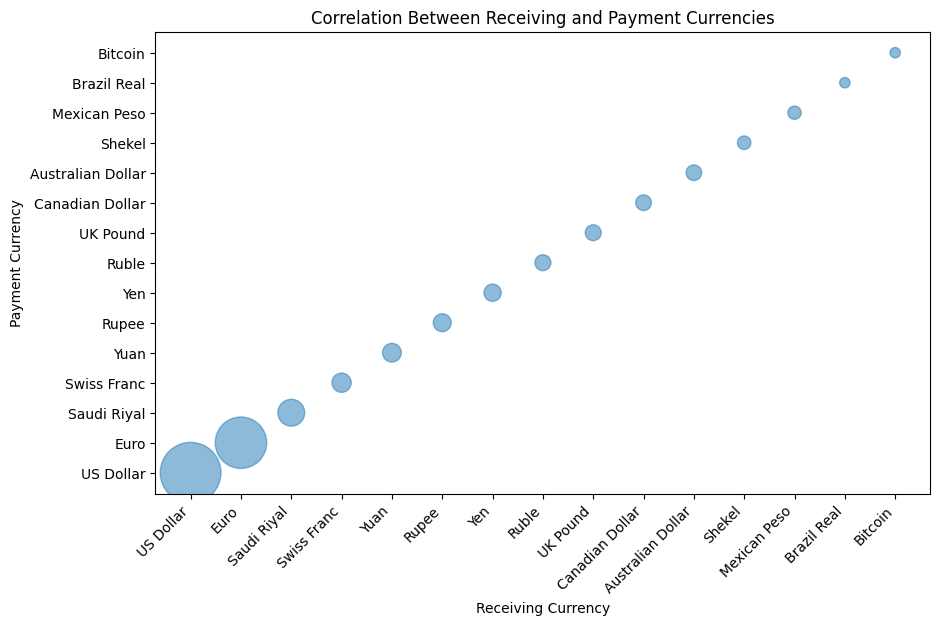

In [6]:
# Analyze most commonly used currencies
most_common_currencies = (
    df.groupBy("ReceivingCurrency", "PaymentCurrency")
    .count()
    .orderBy(col("count").desc())
)
most_common_currencies.show()

# Analyze most commonly used currencies for laundering
currency_correlation = (
    df.filter(col("IsLaundering") == 1)
    .groupBy("ReceivingCurrency", "PaymentCurrency")
    .count()
    .orderBy(col("count").desc())
)
currency_correlation.show()

# Convert to Pandas for plotting
currency_correlation_pd = currency_correlation.toPandas()

# Plotting a scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
plt.scatter(
    currency_correlation_pd['ReceivingCurrency'],
    currency_correlation_pd['PaymentCurrency'],
    s=currency_correlation_pd['count'] ,  # Adjust marker size based on transaction count
    alpha=0.5
)
plt.title('Correlation Between Receiving and Payment Currencies')
plt.xlabel('Receiving Currency')
plt.ylabel('Payment Currency')
plt.xticks(rotation=45, ha='right')
plt.show()

### 3.2 How do transaction counts vary across different banks and payment formats, and is there a discernible correlation between specific banks and payment formats in potentially fraudulent transactions?

+--------+-------------+------+
|FromBank|PaymentFormat| count|
+--------+-------------+------+
|      70|       Cheque|213698|
|      70|  Credit Card|134680|
|      70|         Cash| 88408|
|      10|       Cheque| 33198|
|      12|       Cheque| 32690|
|       1|       Cheque| 25354|
|      10|  Credit Card| 22429|
|      12|  Credit Card| 21809|
|       1|  Credit Card| 17209|
|      15|       Cheque| 16607|
|      20|       Cheque| 16551|
|     220|       Cheque| 16048|
|       3|       Cheque| 15267|
|     124|      Bitcoin| 13920|
|     126|      Bitcoin| 13637|
|     220|      Bitcoin| 13454|
|      70|      Bitcoin| 13073|
|      11|       Cheque| 12378|
|     225|      Bitcoin| 12376|
|     211|       Cheque| 12353|
+--------+-------------+------+
only showing top 20 rows



+--------+-------------+-----+
|FromBank|PaymentFormat|count|
+--------+-------------+-----+
|      70|       Cheque|  301|
|      70|  Credit Card|  206|
|      70|         Cash|  108|
|      12|          ACH|   76|
|      20|          ACH|   67|
|     119|          ACH|   59|
|      10|          ACH|   51|
|       1|          ACH|   50|
|      11|          ACH|   47|
|      15|          ACH|   44|
|      22|          ACH|   40|
|     118|          ACH|   36|
|     223|          ACH|   35|
|     222|          ACH|   33|
|   15231|          ACH|   33|
|  213952|          ACH|   33|
|    1267|          ACH|   33|
|   21611|          ACH|   33|
|      23|          ACH|   32|
|  148350|          ACH|   31|
+--------+-------------+-----+
only showing top 20 rows



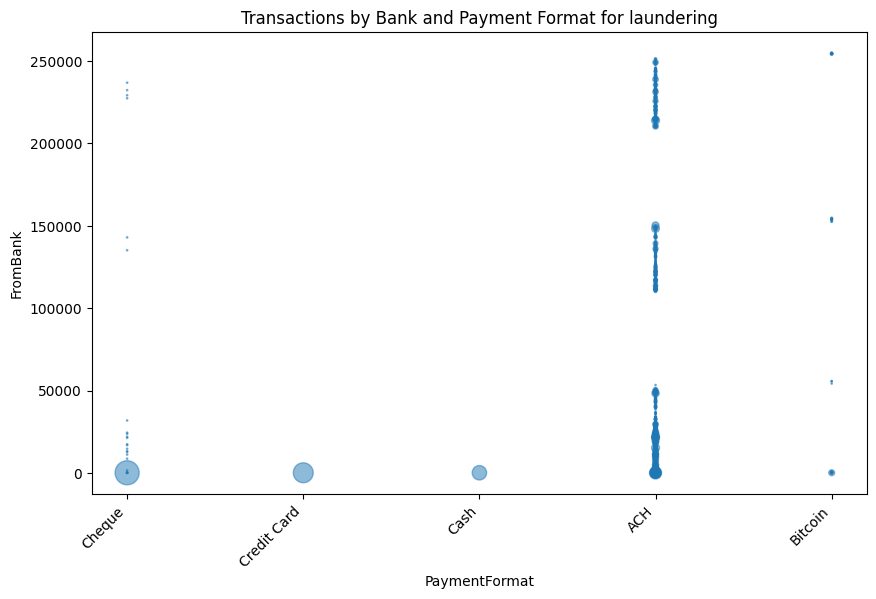

In [7]:
#Transaction Counts by Bank and Payment Format
transactions_by_bank_format = (
    df.groupBy("FromBank", "PaymentFormat")
    .count()
    .orderBy(col("count").desc())
)

transactions_by_bank_format.show()

#Transaction Counts by Bank and Payment Format for laundering
transactions_by_bank_format_ln = (
    df.filter(col("IsLaundering") == 1)
    .groupBy("FromBank", "PaymentFormat")
    .count()
    .orderBy(col("count").desc())
)

transactions_by_bank_format_ln.show()


# Convert to Pandas for plotting
transactions_by_bank_format_ln_pd = transactions_by_bank_format_ln.toPandas()

# Plotting a scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
plt.scatter(
    transactions_by_bank_format_ln_pd['PaymentFormat'],
    transactions_by_bank_format_ln_pd['FromBank'],
    s=transactions_by_bank_format_ln_pd['count'] ,  # Adjust marker size based on transaction count
    alpha=0.5
)
plt.title('Transactions by Bank and Payment Format for laundering')
plt.xlabel('PaymentFormat')
plt.ylabel('FromBank')
plt.xticks(rotation=45, ha='right')
plt.show()

### 3.3 Which specific account interactions are the most common in transactions (Top 10), and is there a discernible pattern in specific account interactions associated with potentially fraudulent transactions?

In [8]:
# Analyze specific accounts (from and to)
most_common_accounts = (
    df.groupBy("FromAccount", "ToAccount")
    .count()
    .orderBy(col("count").desc())
)

# Convert to Pandas for plotting
most_common_accounts.show(10)

# Analyze specific accounts (from and to) for laundering
most_common_accounts_ln = (
    df.filter(col("IsLaundering") == 1) 
    .groupBy("FromAccount", "ToAccount")
    .count()
    .orderBy(col("count").desc())
)

# Convert to Pandas for plotting
most_common_accounts_ln.show(10)


+-----------+---------+-----+
|FromAccount|ToAccount|count|
+-----------+---------+-----+
|  80006FCE0|80006FCE0|   89|
|  8000D09B0|8000D09B0|   69|
|  800069AA0|800069AA0|   66|
|  8007E86B0|8007E86B0|   65|
|  800057020|800057020|   65|
|  813424001|813424001|   63|
|  80006AC70|80006AC70|   62|
|  80005B9B0|80005B9B0|   62|
|  8003231B0|8003231B0|   61|
|  8000A6010|8000A6010|   60|
+-----------+---------+-----+
only showing top 10 rows



+-----------+---------+-----+
|FromAccount|ToAccount|count|
+-----------+---------+-----+
|  80266F880|8021353D0|   27|
|  8021353D0|80266F880|   20|
|  812A09D40|812A09CF0|   18|
|  812A09CF0|812A09D40|   15|
|  812A70ED0|812A70E80|   10|
|  811C597B0|811C599A0|   10|
|  812D22980|811C599A0|   10|
|  811C599A0|811C597B0|   10|
|  812D0C3C0|812D0C600|    9|
|  811FFF630|812D0C3C0|    8|
+-----------+---------+-----+
only showing top 10 rows



### 3.4 Which are the accounts with suspicious transaction spikes in the entire dataset?

+---------+-------------------+-----------------+---------+
|ToAccount|          Timestamp|previous_accounts|hop_count|
+---------+-------------------+-----------------+---------+
|800051110|2022-09-07 20:02:00|      [811B6E170]|        1|
|800051110|2022-09-08 06:18:00|      [811A4DBD0]|        1|
|800051110|2022-09-10 15:19:00|      [8000E1590]|        1|
|800054B70|2022-09-03 08:47:00|      [8001FE5D0]|        1|
|800054B70|2022-09-08 02:28:00|      [80012E0B0]|        1|
+---------+-------------------+-----------------+---------+
only showing top 5 rows



/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


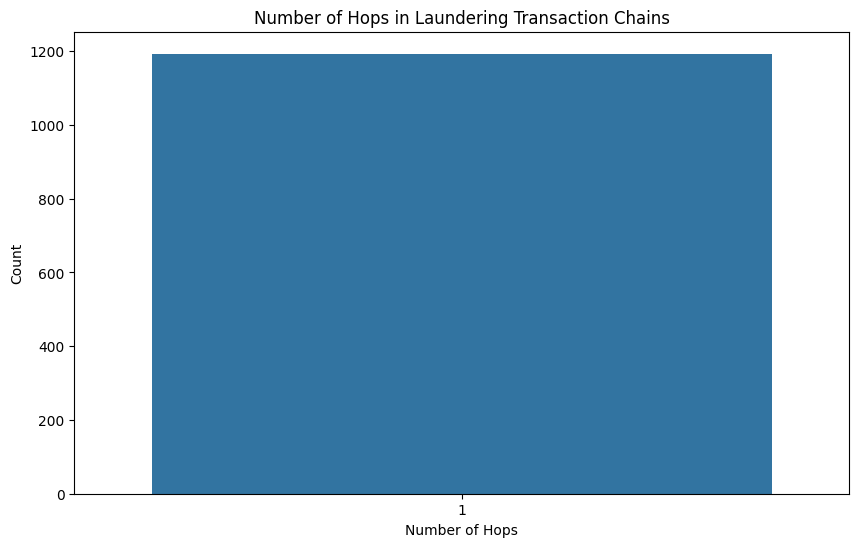

In [9]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, col, collect_list, size
import seaborn as sns
import matplotlib.pyplot as plt

# Define the window specification
chain_window = Window.partitionBy("ToAccount").orderBy("Timestamp")

# Calculate previous accounts and count the number of hops
chains_df = df.filter("IsLaundering = 1") \
              .withColumn("prev_account", lag("FromAccount", 1).over(chain_window)) \
              .filter("prev_account is not null") \
              .groupBy("ToAccount", "Timestamp") \
              .agg(collect_list("prev_account").alias("previous_accounts"))

# Add a new column for hop count
chains_df = chains_df.withColumn("hop_count", size("previous_accounts"))

# Sort the DataFrame by hop_count in descending order
chains_df = chains_df.orderBy("hop_count", ascending=False)

# Show the top 5 records
chains_df.show(5)

# Visualize using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.countplot(data=chains_df.toPandas(), x="hop_count")
plt.title('Number of Hops in Laundering Transaction Chains')
plt.xlabel('Number of Hops')
plt.ylabel('Count')
plt.show()



## 4. Model Building

### 4.1 Up-sample minority class

In [10]:
laundering_df = df.filter("IsLaundering = 1")

# Create a 40% sample of the laundering_df DataFrame
sampled_laundering_df = laundering_df.sample(False, 0.4, seed=42)

# Union the original DataFrame with the sampled laundering DataFrame
balanced_df = df.union(sampled_laundering_df)

In [11]:

# Show the first few rows of the resulting DataFrame
balanced_df.count()

5080449

### 4.2 Down-sample majority class

In [12]:
# Create a negative sample (non-laundering transactions) with a 10% sample rate
neg_df = df.filter("IsLaundering = 0").sample(False, 0.1, seed=42)

# Union the original laundering transactions with the negative sample
balanced_df = laundering_df.union(neg_df)


In [13]:
# Show the first few rows of the resulting DataFrame
balanced_df.count()

513145

### Split Data into Training and Testing Sets


In [14]:
(train_df, test_df) = balanced_df.randomSplit([0.75, 0.25], seed=42)

In [15]:
train_df.count()

384614

In [16]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression

# List of categorical columns
categorical_columns = ["ReceivingCurrency", "PaymentCurrency", "PaymentFormat"]

# StringIndexer stages for handling categorical columns
indexers_train = [StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(train_df) for col in categorical_columns]
indexers_test = [StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(test_df) for col in categorical_columns]

In [17]:
# Feature columns including the newly created indices
exclude_columns = ["Timestamp", "FromAccount", "ToAccount"]
all_columns = balanced_df.columns
feature_columns = [f"{col}_index" if col in categorical_columns else col for col in all_columns if col not in exclude_columns]

# Include IsLaundering in the feature columns
feature_columns.append("IsLaundering")

# Apply StringIndexer transformations for training data
for indexer in indexers_train:
    train_df = indexer.transform(train_df)

# Feature vector assembly for training data
vector_assembler_train = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembler_train_df = vector_assembler_train.transform(train_df)

# Drop original categorical columns and IsLaundering for training data
assembler_train_df = assembler_train_df.drop(*categorical_columns)



In [18]:
# Apply StringIndexer transformations for test data
for indexer in indexers_test:
    test_df = indexer.transform(test_df)

# Feature vector assembly for test data
vector_assembler_test = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembler_test_df = vector_assembler_test.transform(test_df)

# Drop original categorical columns and IsLaundering for test data
assembler_test_df = assembler_test_df.drop(*categorical_columns)


In [19]:
# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="IsLaundering")
model = lr.fit(assembler_train_df)


In [20]:
# Specify the path where you want to save the model
model_path = "logistic_regression_model"

# Save the model
#model.save(model_path)
model.write().overwrite().save(model_path)

In [21]:
from pyspark.ml.classification import LogisticRegressionModel

# Load the saved model
loaded_model = LogisticRegressionModel.load(model_path)

In [22]:
assembler_train_df.columns

['Timestamp',
 'FromBank',
 'FromAccount',
 'ToBank',
 'ToAccount',
 'AmountReceived',
 'AmountReceivedUSD',
 'AmountPaid',
 'AmountPaidUSD',
 'IsLaundering',
 'ReceivingCurrency_index',
 'PaymentCurrency_index',
 'PaymentFormat_index',
 'features']

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Replace 'test_df' with your actual test dataset
test_df = assembler_test_df

# Make predictions on the test set using the loaded model
predictions = loaded_model.transform(test_df)

# Create a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="IsLaundering", metricName="areaUnderROC")

# Evaluate the model and get the AUC score
auc_score = evaluator.evaluate(predictions)
print(f"Area Under ROC (AUC): {auc_score}")


Area Under ROC (AUC): 0.9999883059782377


In [24]:
# Penalize algorithms based on sensitivity

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Replace 'test_df' with your actual test dataset
test_df = assembler_test_df

# Make predictions on the test set using the loaded model
predictions = loaded_model.transform(test_df)

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="IsLaundering", metricName="f1")

# Evaluate the model and get the F1 score
f1_score = evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")


F1 Score: 1.0


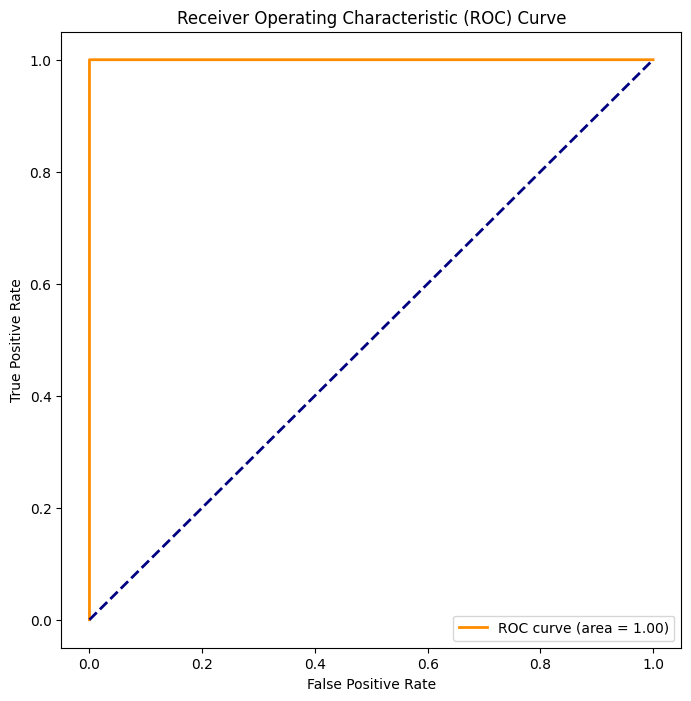

Area Under ROC (AUC): 1.0


In [25]:
from sklearn.metrics import roc_curve, auc
# Convert PySpark DataFrame to Pandas DataFrame
predictions_pandas = predictions.select("IsLaundering", "probability").toPandas()

# Get the true positive rate, false positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(predictions_pandas["IsLaundering"], predictions_pandas["probability"].apply(lambda x: x[1]))

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f"Area Under ROC (AUC): {roc_auc}")

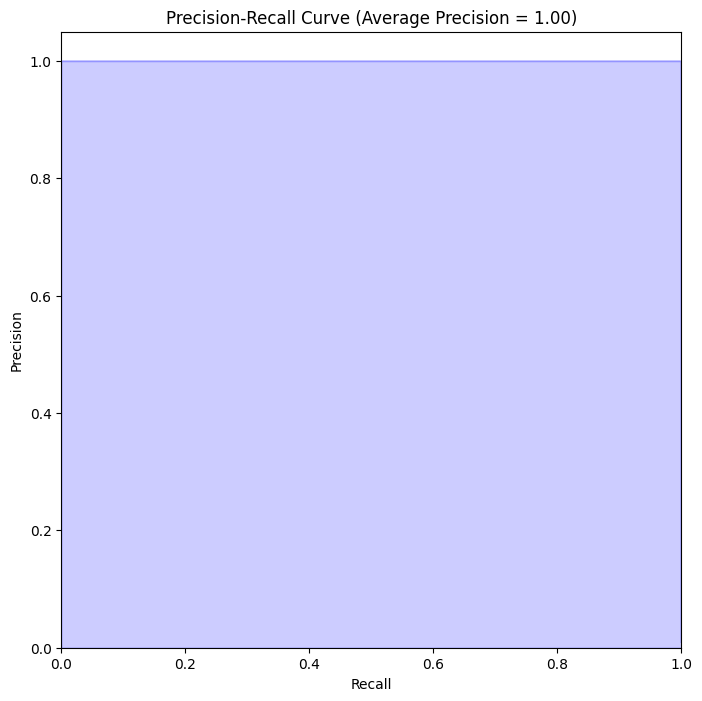

Average Precision: 1.0


In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pandas = predictions.select("IsLaundering", "probability").toPandas()

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(predictions_pandas["IsLaundering"], predictions_pandas["probability"].apply(lambda x: x[1]))

# Calculate the average precision
average_precision = average_precision_score(predictions_pandas["IsLaundering"], predictions_pandas["probability"].apply(lambda x: x[1]))

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {:.2f})'.format(average_precision))
plt.show()

# Print the average precision
print(f"Average Precision: {average_precision}")

In [27]:
from pyspark.ml import Pipeline  
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="IsLaundering", featuresCol="features", maxIter=5)
pipeline = Pipeline(stages=[gbt])  

gbt_model = pipeline.fit(assembler_train_df)

In [28]:
gbt_model.write().overwrite().save("gbt_model_5_iter")

#### The GBTClassifier in PySpark does not have a direct parameter for the number of epochs like some other machine learning libraries. Instead, it uses the maxIter parameter to control the maximum number of iterations (trees) in the ensemble. If you want to simulate the concept of epochs in the context of a gradient-boosted tree model, you can set the maxIter parameter to the desired number of "epochs." Each iteration (epoch) adds a new tree to the ensemble.



In [29]:
from pyspark.ml import PipelineModel

# Load the GBT model
loaded_gbt_model = PipelineModel.load("gbt_model_5_iter")

# Now, you can use the loaded_gbt_model for predictions on new data
gbt_predictions = loaded_gbt_model.transform(assembler_test_df)

# Show the predictions
gbt_predictions.select("prediction", "IsLaundering").show()

+----------+------------+
|prediction|IsLaundering|
+----------+------------+
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
+----------+------------+
only showing top 20 rows



In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# ROC AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="IsLaundering", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(gbt_predictions)
print(f"ROC AUC: {roc_auc}")

# F1 Score
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="IsLaundering", metricName="f1")
f1_score = multiclass_evaluator.evaluate(gbt_predictions)
print(f"F1 Score: {f1_score}")



ROC AUC: 1.0


F1 Score: 1.0


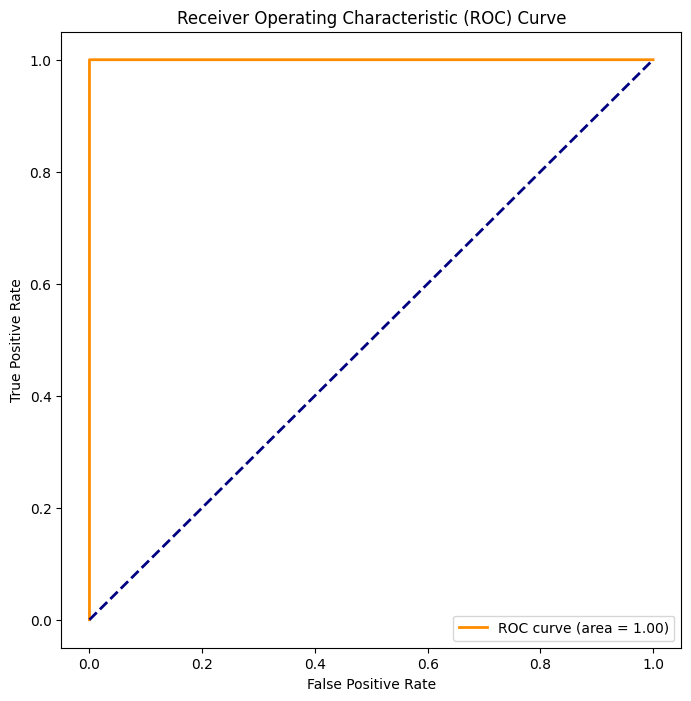

Area Under ROC (AUC): 1.0


In [31]:
from sklearn.metrics import roc_curve, auc
# Convert PySpark DataFrame to Pandas DataFrame
gbt_predictions_pandas = gbt_predictions.select("IsLaundering", "probability").toPandas()

# Get the true positive rate, false positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(gbt_predictions_pandas["IsLaundering"], predictions_pandas["probability"].apply(lambda x: x[1]))

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f"Area Under ROC (AUC): {roc_auc}")

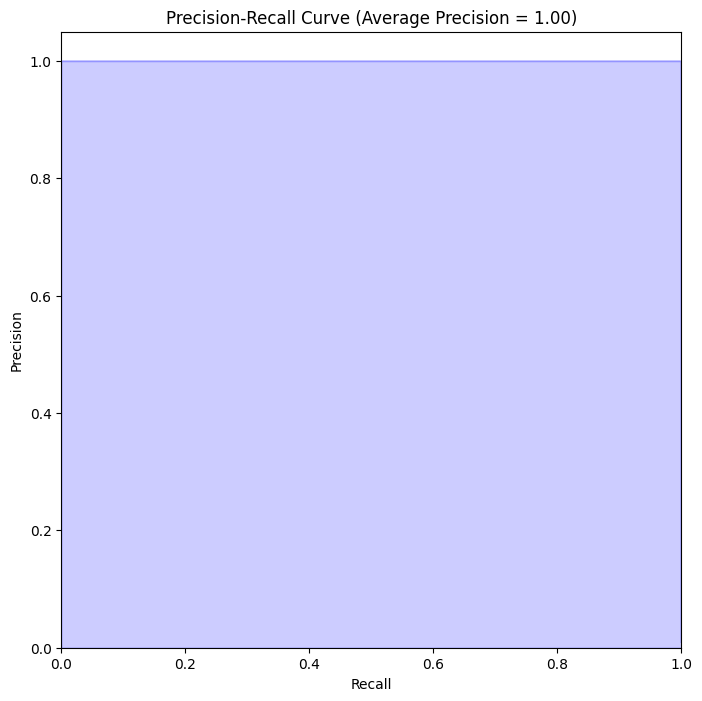

Average Precision: 1.0


In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Convert PySpark DataFrame to Pandas DataFrame
gbt_predictions_pandas = gbt_predictions.select("IsLaundering", "probability").toPandas()

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(gbt_predictions_pandas["IsLaundering"], predictions_pandas["probability"].apply(lambda x: x[1]))

# Calculate the average precision
average_precision = average_precision_score(gbt_predictions_pandas["IsLaundering"], predictions_pandas["probability"].apply(lambda x: x[1]))

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {:.2f})'.format(average_precision))
plt.show()

# Print the average precision
print(f"Average Precision: {average_precision}")